#  Mathematics of Reinforcement Learning: Homework Sheet 3

In this homework sheet we create our first own Gymnasium enviroment. The value function is calculated in 2 different ways and 2 different policies are compared.

Make sure you have all the necessary packages (gymnasium, numpy, matplotlib) installed. You can use `conda install <package>` or `pip install <package>`.

In [3]:
#It may be possible to run the following line of code to install packages:
#!pip install gymnasium

In [4]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

## Exercises 1-2
The theoretical exercises 1 and 2 can be found in the PDF file. 

## Exercise 3
In this exercise we implement the optimal investment Makrov Decision Model from Exercise sheet 2, Task 4 into a Gymnasium enviroment. We will always terminate the Markov Decision Model when the time horizon `T` is reached.

### Task 3.1
Fill in the blanks in the `optimal_investment_gym.py` file. 

### Task 3.2
Check that the environment behaves correctly.

In [5]:
#Market parameters
T = 3     #Time horizon
u = 2.0   #CRR parameter, up factor change
d = -.5   #CRR parameter, down factor change
q = .5    #CRR parameter, probability of up change

In [6]:
#In the following way custom gymnasium enviroments can be imported
gym.register(
    id='optimal_investment-v0',
    entry_point='optimal_investment_gym_solution:optimal_investment_env',
)

env = gym.make('optimal_investment-v0', T=T, d=d, u=u, q=q)

In [7]:
#We define the start state, which will be used in some test functions.
start_state = {'timepoint': np.array([0.]),
               'asset price': np.array([8.]),
               'wealth': np.array([100.])}

In [8]:
assert env.reset()[0] == start_state   # check that the start state is correct

In [9]:
env.reset()

({'timepoint': array([0.]),
  'asset price': array([8.]),
  'wealth': array([100.])},
 {})

In [10]:
env.step(np.array([48]))

({'timepoint': array([1.]),
  'asset price': array([4.]),
  'wealth': array([76.])},
 0,
 False,
 False,
 {})

## Exercise 4
In this exercise we will compute the value function of the Optimal Investment Markov Decision Process in 2 different ways for 2 different policies. 

**Task 4.1** Implement a helping function `create_state(t,p,w)` that takes as input float values (or numpy arrays) `t,p,w` and returns an element from the observation space with timestep parameter `t`, asset price `p` and wealth `w`.

In [11]:
def create_state(t,p,w):
    # ---- TODO ----
    if type(t)==type(p) and type(p)==type(w) and not type(t)==np.ndarray:
        return {'timepoint': np.array([t]), 'asset price': np.array([p]), 'wealth': np.array([w])}
    elif type(t)==type(p) and type(p)==type(w):
        return {'timepoint': t, 'asset price': p, 'wealth': w}
    else: 
        raise Exception("Type mismatch in the create state function")

**Task 4.2** Implement a function `first_policy(observation)` that takes as input `observation`, an element of the observation space and returns an action, that represents investing half of the current wealth (rounded up to the next risky asset price) in the risky asset. The output should be a numpy array of shape `(1,)`.

In [12]:
def first_policy(observation):
    # ---- TODO ----
    action = np.ceil((observation["wealth"]/observation["asset price"])/2) * observation["asset price"]
    return action

In [13]:
assert first_policy(start_state) == 56  #this should be true

**Task 4.3** Implement a function `second_policy(observation)` that takes as input `observation`, an element from the observation space, and returns an action that represents investing as much wealth as possible in the risky asset if the current wealth is less than or equal to 150, otherwise investing a quarter (rounded up) of the current wealth in the risky asset. The output should be a numpy array of shape `(1,)`.

In [14]:
def second_policy(observation):
    # ---- TODO ----
    if observation["wealth"]<=150:
        action = np.floor(observation["wealth"]/observation["asset price"]) * observation["asset price"]
    else:
        action = np.ceil((observation["wealth"]/observation["asset price"])/4) * observation["asset price"]
    return action

In [15]:
assert second_policy(start_state) == 96 #this should be true

**Task 4.4** Implement a function `empirical_value_function(observation, policy)` that takes as input `observation`, an element from the observation space and a policy `policy` and returns the empirical value function of the state `observation` following the policy `policy`. This should be done by simulating `1000` paths of the Markov Decision Model starting in state `observation` and following the policy `policy`. Return the mean accumulated reward.  

*Hints:*
1. If the timepoint is equal to `T`, calculate and return the reward immidiately.        
2. Use the options feature of the `env.reset()` function.

In [16]:
def empirical_value_function(observation, policy):
    # ---- TODO ----
    
    if observation["timepoint"]==T:
        return np.log(observation["wealth"])
    
    reward_list = []
    
    for i in range(1000):
        terminated = False
        obs, _ = env.reset(options = observation)
        while not terminated:
            action = policy(obs)
            obs, reward, terminated, truncated, info = env.step(action)
        reward_list.append(reward)
    return np.mean(reward_list)

print("This value:",empirical_value_function(start_state, first_policy), "should be close to",5.2305082745198215)

This value: 5.2473232330452575 should be close to 5.2305082745198215


**Task 4.5** Implement a helping function `next_state(policy, observation, R)` that takes as input a policy `policy`, an observation `observation` and a risky asset factor change `R` and outputs the next state, given the current state `observation`, following the policy `policy` and given the risky asset factor change `R`.

*Hint: Use the helping function `create_state(t,p,w)`*

In [17]:
def next_state(policy, observation, R):
    # ---- TODO ----
    action = policy(observation)

    
    next_asset_price = observation["asset price"] * (1+R)
    next_wealth = observation["wealth"] + action[0] * R
    
    return create_state(observation["timepoint"] + 1, next_asset_price, next_wealth)

**Task 4.6** Implement a function `value_function(observation, policy)` that takes as input `observation`, an element from the observation space, and a policy `policy` and returns the value function of the state `observation` following the policy `policy`, computed with the Bellman equation, derived for the optimal investment problem in Exercise 2 of this week's homework sheet.

*Hint: Define the function recursively and use the helping function `next_state(policy, observation, R)`*.

In [18]:
def value_function(observation, policy):
    # ---- TODO ----
    
    if observation["timepoint"] == 3:
        return np.log(observation["wealth"])
    
    #else calculate next possible states
    values = [] #save the different values
    
    for R in [d,u]:
        new_state = next_state(policy, observation, R)
        values.append(.5 * value_function(new_state, policy))
        
    return np.sum(values)
    

In [19]:
assert np.isclose(value_function(start_state, first_policy),5.2335903897176745) #check that correctly programmed

The following function visualises the different paths in the CRR model following a policy `policy`. The value (given by the functions `value_function` and `emprical_value_function`) of each state is shown in red, and the current asset price is shown in blue.

**Task 4.7:** Check that the function `empirical_value_function` returns similar results as the function `value_function`.

In [17]:
#inspired from https://python-fiddle.com/saved/XC4sUFiiEJeWKTdEs9Gz
#only works for T=3
def visualise_path_tree(policy, func, title_extra = "", ylabel  = ""):
    assert T == 3
    
    list_states = [[start_state]]
    for i in range(T):
        list_states.append([])
        for state in list_states[-2]:
            for R in [-0.5,2]:
                list_states[-1].append(next_state(policy, state, R))
    y_positions = [[4.5],[2.5,6.5],[1.5,3.5,5.5,7.5],[i+1 for i in range(8)]]
    
    plt.figure(figsize = (8,6))
    for i in range(T+1):
        for j in range(len(list_states[i])):
            if i<T:
                x1, y1 = [i, i+1], [y_positions[i][j],y_positions[i+1][2*j]]
                plt.plot(x1, y1, marker = 'o',color="gray")
                x1, y1 = [i, i+1], [y_positions[i][j],y_positions[i+1][2*j+1]]
                plt.plot(x1, y1, marker = 'o',color="black")
            plt.text(i-0.05,y_positions[i][j]-0.35,"%.3f" % func(list_states[i][j], policy),color="red")
            plt.text(i-0.05,y_positions[i][j]-0.6,"%.0f" % list_states[i][j]["asset price"],color="blue")
    plt.title("Value function and asset prices for all possible states"+title_extra)

    plt.xlim([-0.3,3.3])
    plt.xlabel("Timepoint $t$")
    plt.ylim([0.3,8.3])
    plt.ylabel(ylabel)
    plt.xticks([0,1,2,3])
    plt.yticks([])
    plt.show()


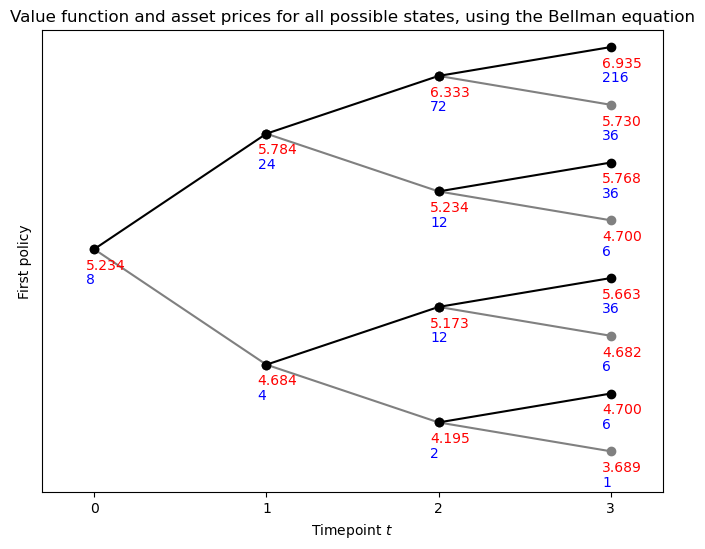

In [18]:
visualise_path_tree(first_policy, value_function, title_extra = ", using the Bellman equation", 
                    ylabel = "First policy")

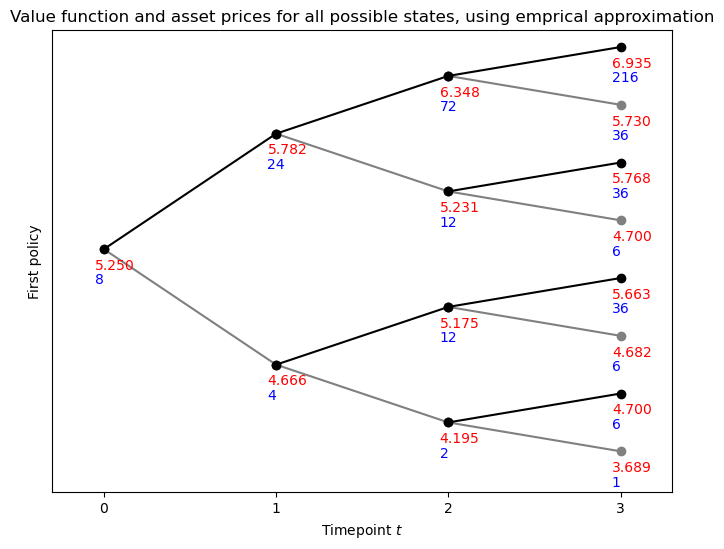

In [19]:
visualise_path_tree(first_policy,empirical_value_function, title_extra = ", using emprical approximation", 
                    ylabel = "First policy")

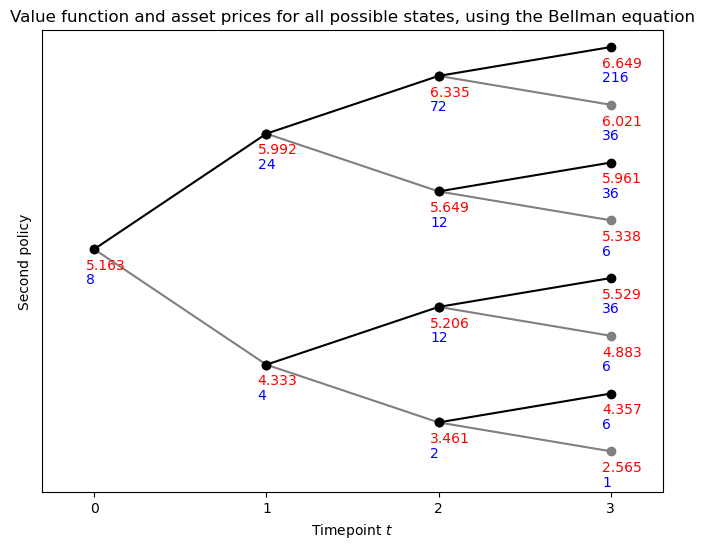

In [20]:
visualise_path_tree(second_policy, value_function, title_extra = ", using the Bellman equation",
                   ylabel = "Second policy")

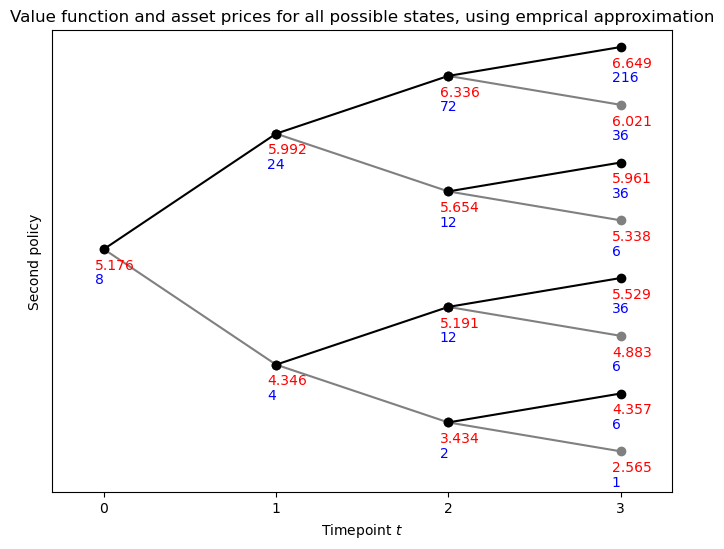

In [21]:
visualise_path_tree(second_policy, empirical_value_function, title_extra = ", using emprical approximation",
                    ylabel = "Second policy")

**Task 4.8:** Analyse the plots above. Which policy performs better?